In [ ]:
from lib.models import *
from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader
import torch
from torch import nn
from tqdm import tqdm
from lib.utils import cms,test_evaluation
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
import plotly.express as px
import pandas as pd
from lib.utils import get_bout_statistics_for_predictions
import numpy as np
import seaborn as sns
from lib.utils import load_raw_by_path
from lib.utils import load_raw_by_path
from torch import nn
from torch.nn.functional import batch_norm,relu
from torch import nn
import numpy as np
from torch.nn.functional import softmax
import torch
import sqlite3
from sqlite3 import Error
import os
import pandas as pd
from tqdm import tqdm
from lib.models import ResNet as MODEL
from torch.utils.data import DataLoader,TensorDataset

device = 'cuda'
model = BigPapa().to(device)
model.load_state_dict(torch.load('../models/84.pt',map_location='cuda'))

params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)

EEG_1 = [1,8,14,15,16]
EEG_2 = [3,4,5,6,7,9,10,11,12,13,17]

In [ ]:
def score_file(fileindex):
    raw = load_raw_by_path(f'../data/full/1_raw_edf/22-AGING-{fileindex}.edf').get_data(picks=['EEG','EMG'])

    if(fileindex in EEG_1):
        eeg = raw[0]
    elif(fileindex in EEG_2):
        eeg = raw[1]
    else:
        print("error")

    X = torch.from_numpy(eeg.reshape(-1,5000)).float()

    # center, stretch
    X = (X - X.mean(axis=1,keepdim=True))/X.std(axis=1,keepdim=True)
    if(X.isinf().any()):
        print("inf")
        
    windowsize = 9
    # only works for odd windows, puts label at center
    cat = [X[:-(windowsize-1)]]
    for i in range(1,(windowsize-1)):
        cat.append(X[i:i-(windowsize-1)])
    cat.append(X[(windowsize-1):])
    X = torch.cat(cat,axis=1).float()
    dataloader = DataLoader(TensorDataset(X),batch_size=16)
    y_pred = torch.Tensor().cuda()
    model.eval()
    for (X_test) in tqdm(dataloader):
        X_test = X_test[0].to(device)
        logits = model(X_test)
        y_pred = torch.cat([y_pred,torch.softmax(logits,dim=1).argmax(axis=1)])
    pred_expert = y_pred.cpu().numpy()

    for j in range(len(pred_expert)-2):
        if(pred_expert[j+1] != pred_expert[j] and pred_expert[j+1] != pred_expert[j+2]):
            pred_expert[j+1] = pred_expert[j]
    df = pd.DataFrame([pred_expert]).T
    df[df[0] == 0] = 'P'
    df[df[0] == 1] = 'S'
    df[df[0] == 2] = 'W'
    if(not os.path.isdir(f'aging_pred')):
        os.system('mkdir aging_pred')
    df.to_csv(f'aging_pred/{fileindex}.csv',index=False)

    rename_dict = {'W':'Sleep-Wake', 'S':'Sleep-SWS', 'P':'Sleep-Paradoxical', 'X':''}
    offset = 10e7       #epoch time period
    csv_filename = f'aging_pred/{fileindex}.csv'
    zdb_filename = f'results_zdb/22-AGING-{fileindex}.zdb'

    df = pd.read_csv(csv_filename)
    try:
        conn = sqlite3.connect(zdb_filename)
    except Error as e:
        print(e)
    cur = conn.cursor()

    #drop this table - creates issues
    query = "DROP TABLE IF EXISTS temporary_scoring_marker;"
    cur.execute(query)

    #get keyid of scoring
    query = "SELECT MAX(id) FROM scoring_revision WHERE name='Machine Data'"
    cur.execute(query)
    keyid = cur.fetchall()[0][0]

    #get starting point for scoring
    query = "SELECT id FROM scoring_marker WHERE type LIKE 'Sleep%' AND key_id='"+str(keyid)+"';"
    cur.execute(query)
    startid = cur.fetchall()[0][0]

    #get start time to crreate epochs
    query = 'SELECT starts_at FROM scoring_marker WHERE id = '+str(startid)+";"
    cur.execute(query)
    start_time = cur.fetchall()[0][0]
    stop_time = 0

    #delete first score before adding machine data
    query = "DELETE FROM scoring_marker;"
    cur.execute(query)

    #insert new epochs with scoring into the table
    for i in range(len(df)):
        #calculate epoch
        if i != 0:
            start_time = stop_time
        stop_time = start_time+offset

        score = rename_dict[df.at[i,'0']]
        #insert epoch
        query = f"""
                INSERT INTO scoring_marker 
                (starts_at, ends_at, notes, type, location, is_deleted, key_id)
                VALUES 
                ({start_time}, {stop_time}, '', '{score}', '', 0, {keyid});
                """ 
        cur.execute(query)

    conn.commit()
    conn.close()

In [ ]:
for fileindex in range(7,8):
    print(fileindex)
    if(not os.path.isdir('results_zdb')):
        raise Exception("results_zdb not provided, copy raw zdb to directory")
    if(fileindex == 2):
        continue
    score_file(fileindex)

In [24]:
rename_dict = {'W':'Sleep-Wake', 'S':'Sleep-SWS', 'P':'Sleep-Paradoxical', 'X':''}
offset = 10e7       #epoch time period
csv_filename = f'aging_pred/{fileindex}.csv'
# zdb_filename = f'results_zdb/22-AGING-{fileindex}.zdb'

df = pd.read_csv(csv_filename)

In [43]:
from lib.utils import load_raw_by_path
raw = load_raw_by_path(f'../data/aging/1_raw_edf/22-AGING-7.edf')
eeg,t = raw.get_data(picks='EEG',start=0,stop=None,return_times=True)
eeg = eeg.reshape(-1,5000)

In [48]:
t.shape[0]/5000

26756.0

In [44]:
eeg.shape

(26756, 5000)

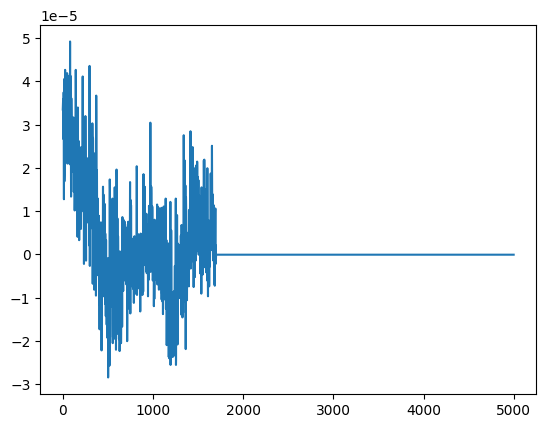

: 

In [49]:
plt.plot(eeg[-1])

In [ ]:

    #delete first score before adding machine data
    query = "DELETE FROM scoring_marker;"
    cur.execute(query)

    #insert new epochs with scoring into the table
    for i in range(len(df)):
        #calculate epoch
        if i != 0:
            start_time = stop_time
        stop_time = start_time+offset

        score = rename_dict[df.at[i,'0']]
        #insert epoch
        query = f"""
                INSERT INTO scoring_marker 
                (starts_at, ends_at, notes, type, location, is_deleted, key_id)
                VALUES 
                ({start_time}, {stop_time}, '', '{score}', '', 0, {keyid});
                """ 
        cur.execute(query)

    conn.commit()
    conn.close()

In [23]:
(637897797500000000-637894317490000000)*10e-9

34800.1